In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


In [2]:

# Define dataset paths
train_dir = "/kaggle/input/undersample-majority/undersample_split/1.train"
val_dir = "/kaggle/input/undersample-majority/undersample_split/2.val"

# Image parameters
img_size = (331, 331)  # NASNetLarge default input size
batch_size = 8  # Reduced batch size to avoid OOM

# Data augmentation for training
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen_val.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load NASNetLarge model with pre-trained weights
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks
callbacks = [
    ModelCheckpoint("nasnetlarge_best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Clear memory before training
tf.keras.backend.clear_session()
gc.collect()

# Train model
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)
training_time = time.time() - start_time

# Save final model
model.save("nasnetlarge_retinopathy_final.keras")

# Evaluate model
val_loss, val_acc, val_precision, val_recall = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Generate Classification Report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(val_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))




Found 467 images belonging to 7 classes.
Found 100 images belonging to 7 classes.
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.2293 - loss: 2.6300 - precision: 0.2163 - recall: 0.1263 - val_accuracy: 0.2200 - val_loss: 1.8721 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.4146 - loss: 1.8713 - precision: 0.5037 - recall: 0.3773 - val_accuracy: 0.2800 - val_loss: 1.8916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 715ms/step - accuracy: 0.4992 - loss: 1.6237 - precision: 0.5658 - recall: 0.4233 - val_accuracy: 0.3100 - val_loss: 1.7725 - val_precision: 0.5000 - val_recall: 0.0300 - learning_rate: 1.0000e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 717ms/step - accuracy: 0.5631 - loss: 1.5020 - precision: 0.5876 - recall: 0.4988 - val_accuracy: 0.4000 - val_loss: 1.7082 - val_precision: 0.6000 - val_recall: 0.0900 - learning_rate: 1.0000e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


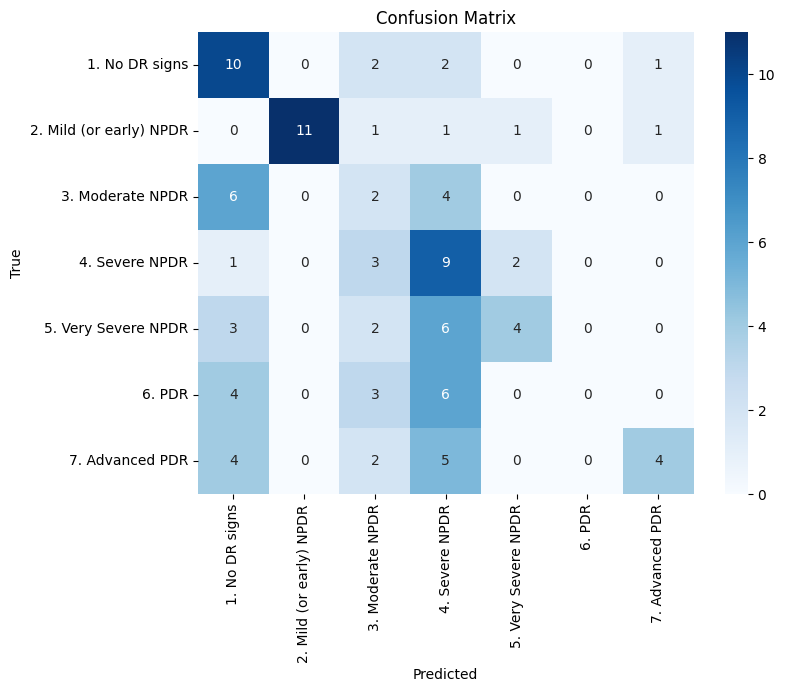

Training Time: 916.61 seconds
Accuracy: 0.4000
Precision: 0.4288
Recall (Sensitivity): 0.3857
F1-Score: 0.3684
Specificity: 0.8999


In [3]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Additional Metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

precision = TP / (TP + FP + 1e-7)
recall = TP / (TP + FN + 1e-7)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
specificity = TN / (TN + FP + 1e-7)
accuracy = np.sum(TP) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")
